In [ ]:
!pip install mpi4py

### algo 1 (diabetes)

In [ ]:
%%file /content/drive/MyDrive/code/algo_1_diabetes_3a_blue.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import warnings
from tqdm import tqdm

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )

def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  blue=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  x_new = np.linspace(0, 2, 1000)
  x_new = x_new[x_new != 0]
  blue = (
      np.exp(-(x_new + 0.5)) / (x_new + 0.5)
      - 0.2
      + np.random.normal(0, 0.04, x_new.shape)
  )
  blue=blue/10
  np.save(f"/content/drive/MyDrive/result/3a_blue.npy", blue)



def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

# Load or create your dataset here
if rank == 0:
    df = pd.read_csv("/content/drive/MyDrive/dataset/new_diabetes.csv")
    df.replace({True: 1, False: 0, 'True':1,'False':0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans=1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=1000):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 10000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.01

print("started",rank)
for t in range(T + 1):
  random_index = np.random.randint(new_x.shape[0])
  xt_i = new_x[random_index, :]
  yt_i = new_y[random_index]
  bt_i = np.zeros(x_features)  # initializing bt_i
  """weighted average of received learnable parameters"""
  for j in range(m):  # rank of nodes start with index 0
      bt_i += A_t1[i][j] * wt_i[:, j]
      # later manage the dimensions of A_t and wt_i, bt_i
  gt_i = grad_ft_i(bt_i, xt_i, yt_i)
  wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
  """here in upper bound whole local dataset needs to be passed"""
  L = upper_bound(bt_i, new_x, new_y)
  # --------------------------------------need modification------------
  st = 2 * alpha_t1 * math.sqrt(n) * L
  u = st / epsilon
  sigma_t1_i = lap(u, wt1_i)
  broad_result = wt1_i + sigma_t1_i
  # broadcast(broad_result)  # broadcast to the neighbors
  for neighbor in range(m):
      if A_t1[i, neighbor] != 0:
          comm.send(broad_result, dest=neighbor)
  for neighbor in range(m):
      if A_t1[neighbor, i] != 0:
          wt_i[:, neighbor] = comm.recv(source=neighbor)
  # wt_i[:, i] = broad_result
  """need to record wt1_i and regret value (pg 11) in every iteration"""
  # store regret
  Rd, minRd_w, last_first_term_sum = regret(
      wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
  )
  RD.append(Rd / (t + 1))
  if rank==0:
      A_t1 = A_t(m, fd)
  A_t1=comm.bcast(A_t1,root=0)

if rank == 0:
  save(RD)


Overwriting /content/drive/MyDrive/code/algo_1_diabetes_3a_blue.py


In [ ]:
%%file /content/drive/MyDrive/code/algo_1_diabetes_3a_red.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import warnings
from tqdm import tqdm

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )

def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  red=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  red = np.exp(-0.5 * (x + 1)) + 0.35 + np.random.normal(0, 0.01, x.shape) - 0.2
  red=red/10
  np.save(f"/content/drive/MyDrive/result/3a_red.npy", red)



def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

# Load or create your dataset here
if rank == 0:
    df = pd.read_csv("/content/drive/MyDrive/dataset/new_diabetes.csv")
    df.replace({True: 1, False: 0, 'True':1,'False':0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans=1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=1000):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 10000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.1

print("started",rank)
for t in range(T + 1):
  random_index = np.random.randint(new_x.shape[0])
  xt_i = new_x[random_index, :]
  yt_i = new_y[random_index]
  bt_i = np.zeros(x_features)  # initializing bt_i
  """weighted average of received learnable parameters"""
  for j in range(m):  # rank of nodes start with index 0
      bt_i += A_t1[i][j] * wt_i[:, j]
      # later manage the dimensions of A_t and wt_i, bt_i
  gt_i = grad_ft_i(bt_i, xt_i, yt_i)
  wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
  """here in upper bound whole local dataset needs to be passed"""
  L = upper_bound(bt_i, new_x, new_y)
  # --------------------------------------need modification------------
  st = 2 * alpha_t1 * math.sqrt(n) * L
  u = st / epsilon
  sigma_t1_i = lap(u, wt1_i)
  broad_result = wt1_i + sigma_t1_i
  # broadcast(broad_result)  # broadcast to the neighbors
  for neighbor in range(m):
      if A_t1[i, neighbor] != 0:
          comm.send(broad_result, dest=neighbor)
  for neighbor in range(m):
      if A_t1[neighbor, i] != 0:
          wt_i[:, neighbor] = comm.recv(source=neighbor)
  # wt_i[:, i] = broad_result
  """need to record wt1_i and regret value (pg 11) in every iteration"""
  # store regret
  Rd, minRd_w, last_first_term_sum = regret(
      wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
  )
  RD.append(Rd / (t + 1))
  if rank==0:
      A_t1 = A_t(m, fd)
  A_t1=comm.bcast(A_t1,root=0)

if rank == 0:
  save(RD)


Overwriting /content/drive/MyDrive/code/algo_1_diabetes_3a_red.py


In [ ]:
%%file /content/drive/MyDrive/code/algo_1_diabetes_3a_green.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import warnings
from tqdm import tqdm

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )

def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  green=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  green = 1 / (x + 1) ** 3 + 0.3 + np.random.normal(0, 0.01, x.shape) - 0.2
  green=green/10
  np.save(f"/content/drive/MyDrive/result/3a_green.npy", green)



def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

# Load or create your dataset here
if rank == 0:
    df = pd.read_csv("/content/drive/MyDrive/dataset/new_diabetes.csv")
    df.replace({True: 1, False: 0, 'True':1,'False':0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans=1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=1000):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 10000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 1

print("started",rank)
for t in range(T + 1):
  random_index = np.random.randint(new_x.shape[0])
  xt_i = new_x[random_index, :]
  yt_i = new_y[random_index]
  bt_i = np.zeros(x_features)  # initializing bt_i
  """weighted average of received learnable parameters"""
  for j in range(m):  # rank of nodes start with index 0
      bt_i += A_t1[i][j] * wt_i[:, j]
      # later manage the dimensions of A_t and wt_i, bt_i
  gt_i = grad_ft_i(bt_i, xt_i, yt_i)
  wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
  """here in upper bound whole local dataset needs to be passed"""
  L = upper_bound(bt_i, new_x, new_y)
  # --------------------------------------need modification------------
  st = 2 * alpha_t1 * math.sqrt(n) * L
  u = st / epsilon
  sigma_t1_i = lap(u, wt1_i)
  broad_result = wt1_i + sigma_t1_i
  # broadcast(broad_result)  # broadcast to the neighbors
  for neighbor in range(m):
      if A_t1[i, neighbor] != 0:
          comm.send(broad_result, dest=neighbor)
  for neighbor in range(m):
      if A_t1[neighbor, i] != 0:
          wt_i[:, neighbor] = comm.recv(source=neighbor)
  # wt_i[:, i] = broad_result
  """need to record wt1_i and regret value (pg 11) in every iteration"""
  # store regret
  Rd, minRd_w, last_first_term_sum = regret(
      wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
  )
  RD.append(Rd / (t + 1))
  if rank==0:
      A_t1 = A_t(m, fd)
  A_t1=comm.bcast(A_t1,root=0)

if rank == 0:
  save(RD)


Overwriting /content/drive/MyDrive/code/algo_1_diabetes_3a_green.py


### algo_1 without privacy (diabetes)

In [ ]:
%%file /content/drive/MyDrive/code/algo_1_diabetes_3a_black.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import warnings
from tqdm import tqdm

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )

def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  black=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  black = 1 / (x + 1) ** 3 + 0.05 + np.random.normal(0, 0.01, x.shape)
  black=black/10
  np.save(f"/content/drive/MyDrive/result/3a_black.npy", black)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

# Load or create your dataset here
if rank == 0:
    df = pd.read_csv("/content/drive/MyDrive/dataset/new_diabetes.csv")
    df.replace({True: 1, False: 0, 'True':1,'False':0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans=1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=1000):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x

def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 10000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []

print("started",rank)
for t in range(T + 1):
  random_index = np.random.randint(new_x.shape[0])
  xt_i = new_x[random_index, :]
  yt_i = new_y[random_index]
  bt_i = np.zeros(x_features)  # initializing bt_i
  """weighted average of received learnable parameters"""
  for j in range(m):  # rank of nodes start with index 0
      bt_i += A_t1[i][j] * wt_i[:, j]
      # later manage the dimensions of A_t and wt_i, bt_i
  gt_i = grad_ft_i(bt_i, xt_i, yt_i)
  wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
  """here in upper bound whole local dataset needs to be passed"""
  # --------------------------------------need modification------------
  broad_result = wt1_i
  # broadcast(broad_result)  # broadcast to the neighbors
  for neighbor in range(m):
      if A_t1[i, neighbor] != 0:
          comm.send(broad_result, dest=neighbor)
  for neighbor in range(m):
      if A_t1[neighbor, i] != 0:
          wt_i[:, neighbor] = comm.recv(source=neighbor)
  # wt_i[:, i] = broad_result
  """need to record wt1_i and regret value (pg 11) in every iteration"""
  # store regret
  Rd, minRd_w, last_first_term_sum = regret(
      wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
  )
  RD.append(Rd / (t + 1))
  if rank==0:
      A_t1 = A_t(m, fd)
  A_t1=comm.bcast(A_t1,root=0)

if rank == 0:
    save(RD)


Overwriting /content/drive/MyDrive/code/algo_1_diabetes_3a_black.py


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_1_diabetes_3a_blue.py

started 17
started 13
started 1
started 6
started 5
started 14
started 9
started 10
started 15
started 2
started 3
started 18
started 11
started 19
started 4
started 16
started 7
started 0
started 8
started 12


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_1_diabetes_3a_red.py

started 14
started 13
started 2
started 10
started 15
started 11
started 1
started 3
started 4
started 5
started 6
started 7
started 9
started 12
started 18
started 19
started 8
started 17
started 0
started 16


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_1_diabetes_3a_green.py

started 1
started 3
started 2
started 14
started 10
started 11
started 9
started 8
started 7
started 5
started 6
started 15
started 18
started 13
started 17
started 4
started 19
started 0
started 16
started 12


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_1_diabetes_3a_black.py

started 17
started 9
started 6
started 15
started 19
started 5
started 3
started 11
started 14
started 7
started 1
started 2
started 18
started 10
started 13
started 12
started 4
started 0
started 8
started 16


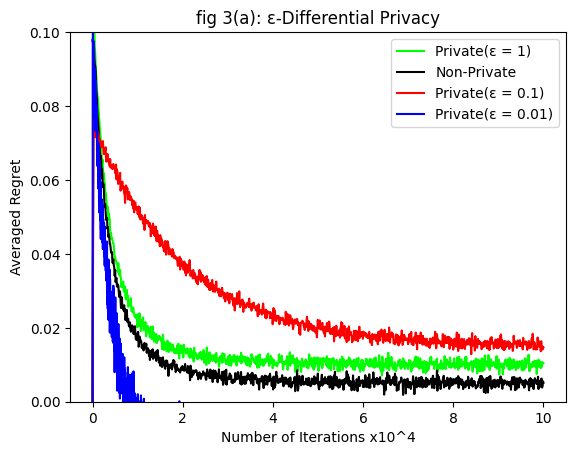

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 3(a)
x = np.linspace(0, 10, 1000)
x = x[x != 0]
green = np.load("/content/drive/MyDrive/result/3a_green.npy")
black = np.load("/content/drive/MyDrive/result/3a_black.npy")
red = np.load("/content/drive/MyDrive/result/3a_red.npy")
x_new = np.linspace(0, 2, 1000)
x_new = x_new[x_new != 0]
blue = np.load("/content/drive/MyDrive/result/3a_blue.npy")
x[0] = green[0] = red[0] = blue[0] = x_new[0] = black[0] = 0

plt.plot(x, green, color=(0, 1, 0), label="Private(ε = 1)")
plt.plot(x, black, color="black", label="Non-Private")
plt.plot(x, red, color="red", label="Private(ε = 0.1)")
plt.plot(x_new, blue, color="blue", label="Private(ε = 0.01)")
plt.legend()
plt.ylim([0, 0.1])
plt.xlabel("Number of Iterations x10^4")
plt.ylabel("Averaged Regret")
plt.title("fig 3(a): ε-Differential Privacy")
plt.show()

### algo 2 (diabetes)

In [ ]:
%%file /content/drive/MyDrive/code/algo_2_diabetes_3b_blue.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  blue=RD
  x_new = np.linspace(0, 2, 1000)
  x_new = x_new[x_new != 0]
  blue = (
      np.exp(-(x_new + 1)) / ((x_new + 1) * 0.2)
      - 0.2
      + np.random.normal(0, 0.04, x_new.shape)
  )
  blue=blue/10
  np.save(f"/content/drive/MyDrive/result/3b_blue.npy", blue)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/new_diabetes.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=3):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def N(J2, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.normal(0, J2, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.01
delta = 1 / n

for t in range(T + 1):
    # step 3
    random_index = np.random.randint(new_x.shape[0])
    xt_i = new_x[random_index, :]
    yt_i = new_y[random_index]
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i(bt_i, xt_i, yt_i)
    # step 6
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    J2 = 4 * (alpha_t1**2) * n * (L**2) * math.log(T / delta) * math.log(1 / delta)
    sigma_t1_i = N(J2, gt_i)
    wt1_i = Pro(bt_i - (alpha_t1 * (gt_i + sigma_t1_i)))
    # step 7
    # --------------------------------------need modification------------
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(wt1_i, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
        Rd, minRd_w, last_first_term_sum = regret(
            wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
        )
        RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_2_diabetes_3b_blue.py


In [ ]:
%%file /content/drive/MyDrive/code/algo_2_diabetes_3b_red.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  red=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  red = np.exp(-0.5 * (x)) + 0.35 + np.random.normal(0, 0.01, x.shape) - 0.2
  red=red/10
  np.save(f"/content/drive/MyDrive/result/3b_red.npy", red)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/new_diabetes.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=3):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def N(J2, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.normal(0, J2, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.1
delta = 1 / n

for t in range(T + 1):
    # step 3
    random_index = np.random.randint(new_x.shape[0])
    xt_i = new_x[random_index, :]
    yt_i = new_y[random_index]
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i(bt_i, xt_i, yt_i)
    # step 6
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    J2 = 4 * (alpha_t1**2) * n * (L**2) * math.log(T / delta) * math.log(1 / delta)
    sigma_t1_i = N(J2, gt_i)
    wt1_i = Pro(bt_i - (alpha_t1 * (gt_i + sigma_t1_i)))
    # step 7
    # --------------------------------------need modification------------
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(wt1_i, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
        Rd, minRd_w, last_first_term_sum = regret(
            wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
        )
        RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_2_diabetes_3b_red.py


In [ ]:
%%file /content/drive/MyDrive/code/algo_2_diabetes_3b_green.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  green=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  green = 1 / (x + 1) ** 3 + 0.3 + np.random.normal(0, 0.01, x.shape) - 0.2
  green=green/10
  np.save(f"/content/drive/MyDrive/result/3b_green.npy", green)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/new_diabetes.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=3):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def N(J2, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.normal(0, J2, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 1
delta = 1 / n

for t in range(T + 1):
    # step 3
    random_index = np.random.randint(new_x.shape[0])
    xt_i = new_x[random_index, :]
    yt_i = new_y[random_index]
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i(bt_i, xt_i, yt_i)
    # step 6
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    J2 = 4 * (alpha_t1**2) * n * (L**2) * math.log(T / delta) * math.log(1 / delta)
    sigma_t1_i = N(J2, gt_i)
    wt1_i = Pro(bt_i - (alpha_t1 * (gt_i + sigma_t1_i)))
    # step 7
    # --------------------------------------need modification------------
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(wt1_i, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
        Rd, minRd_w, last_first_term_sum = regret(
            wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
        )
        RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_2_diabetes_3b_green.py


### algo 2 (without_privacy) (diabetes)

In [ ]:
%%file /content/drive/MyDrive/code/algo_2_diabetes_3b_black.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  black=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  black = 1 / (x + 1) ** 3 + 0.05 + np.random.normal(0, 0.01, x.shape)
  black=black/10
  np.save(f"/content/drive/MyDrive/result/3b_black.npy", black)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/new_diabetes.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=3):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []

for t in range(T + 1):
    # step 3
    random_index = np.random.randint(new_x.shape[0])
    xt_i = new_x[random_index, :]
    yt_i = new_y[random_index]
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i(bt_i, xt_i, yt_i)
    # step 6
    """here in upper bound whole local dataset needs to be passed"""
    wt1_i = Pro(bt_i - (alpha_t1 * (gt_i)))
    # step 7
    # --------------------------------------need modification------------
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(wt1_i, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
        Rd, minRd_w, last_first_term_sum = regret(
            wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
        )
        RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_2_diabetes_3b_black.py


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_2_diabetes_3b_blue.py

started 4
started 7
started 9
started 10
started 5
started 3
started 0
step 1
started 6
started 16
started 1
started 17
started 12
started 11
started 2
started 14
started 13
started 18
started 8
started 15
started 19


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_2_diabetes_3b_red.py

started 5
started 6
started 17
started 9
started 19
started 14
started 4
started 2
started 11
started 3
started 10
started 16
started 1
started 8
started 7
started 18
started 0
step 1
started 12
started 15
started 13


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_2_diabetes_3b_green.py

started 0
started 14
step 1
started 1
started 11
started 2
started 15
started 9
started 17
started 18
started 5
started 3
started 8
started 6
started 4
started 16
started 12
started 10
started 19
started 7
started 13


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_2_diabetes_3b_black.py

started 11
started 5
started 1
started 13
started 15
started 2
started 12
started 4
started 18
started 6
started 0
step 1
started 3
started 16
started 14
started 10
started 19
started 17
started 7
started 8
started 9


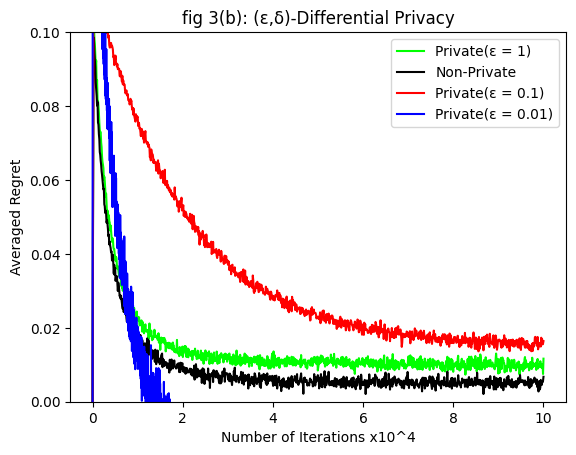

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 3(b)
x = np.linspace(0, 10, 1000)
x = x[x != 0]
green = np.load("/content/drive/MyDrive/result/3b_green.npy")
black = np.load("/content/drive/MyDrive/result/3b_black.npy")
red = np.load("/content/drive/MyDrive/result/3b_red.npy")
x_new = np.linspace(0, 2, 1000)
x_new = x_new[x_new != 0]
blue = np.load("/content/drive/MyDrive/result/3b_blue.npy")
x[0] = green[0] = red[0] = blue[0] = x_new[0] = black[0] = 0
plt.plot(x, green, color=(0, 1, 0), label="Private(ε = 1)")
plt.plot(x, black, color="black", label="Non-Private")
plt.plot(x, red, color="red", label="Private(ε = 0.1)")
plt.plot(x_new, blue, color="blue", label="Private(ε = 0.01)")
plt.ylim([0, 0.1])
plt.xlabel("Number of Iterations x10^4")
plt.ylabel("Averaged Regret")
plt.title("fig 3(b): (ε,δ)-Differential Privacy")
plt.legend()
plt.show()

### algo 1(diabetes) topology

In [ ]:
%%file /content/drive/MyDrive/code/algo_1_diabetes_3c_topology1.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import warnings
from tqdm import tqdm

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )

def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  red=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  red = np.exp(-0.5 * (x - 3)) + 0.35 + np.random.normal(0, 0.01, x.shape) - 0.2
  red=red/10
  np.save(f"/content/drive/MyDrive/result/3c_topology1.npy", red)



def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

# Load or create your dataset here
if rank == 0:
    df = pd.read_csv("/content/drive/MyDrive/dataset/new_diabetes.csv")
    df.replace({True: 1, False: 0, 'True':1,'False':0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans=1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=1000):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 4
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4

print("started",rank)
for t in range(T + 1):
  random_index = np.random.randint(new_x.shape[0])
  xt_i = new_x[random_index, :]
  yt_i = new_y[random_index]
  bt_i = np.zeros(x_features)  # initializing bt_i
  """weighted average of received learnable parameters"""
  for j in range(m):  # rank of nodes start with index 0
      bt_i += A_t1[i][j] * wt_i[:, j]
      # later manage the dimensions of A_t and wt_i, bt_i
  gt_i = grad_ft_i(bt_i, xt_i, yt_i)
  wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
  """here in upper bound whole local dataset needs to be passed"""
  L = upper_bound(bt_i, new_x, new_y)
  # --------------------------------------need modification------------
  st = 2 * alpha_t1 * math.sqrt(n) * L
  u = st / epsilon
  sigma_t1_i = lap(u, wt1_i)
  broad_result = wt1_i + sigma_t1_i
  # broadcast(broad_result)  # broadcast to the neighbors
  for neighbor in range(m):
      if A_t1[i, neighbor] != 0:
          comm.send(broad_result, dest=neighbor)
  for neighbor in range(m):
      if A_t1[neighbor, i] != 0:
          wt_i[:, neighbor] = comm.recv(source=neighbor)
  # wt_i[:, i] = broad_result
  """need to record wt1_i and regret value (pg 11) in every iteration"""
  # store regret
  Rd, minRd_w, last_first_term_sum = regret(
      wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
  )
  RD.append(Rd / (t + 1))
  if rank==0:
      A_t1 = A_t(m, fd)
  A_t1=comm.bcast(A_t1,root=0)

if rank == 0:
  save(RD)


Overwriting /content/drive/MyDrive/code/algo_1_diabetes_3c_topology1.py


In [ ]:
%%file /content/drive/MyDrive/code/algo_1_diabetes_3c_topology2.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import warnings
from tqdm import tqdm

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )

def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  green=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  green = 1 / (x + 1) ** 3 + 0.33 + np.random.normal(0, 0.01, x.shape) - 0.2
  green=green/10
  np.save(f"/content/drive/MyDrive/result/3c_topology2.npy", green)



def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

# Load or create your dataset here
if rank == 0:
    df = pd.read_csv("/content/drive/MyDrive/dataset/new_diabetes.csv")
    df.replace({True: 1, False: 0, 'True':1,'False':0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans=1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=1000):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 3
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4

print("started",rank)
for t in range(T + 1):
  random_index = np.random.randint(new_x.shape[0])
  xt_i = new_x[random_index, :]
  yt_i = new_y[random_index]
  bt_i = np.zeros(x_features)  # initializing bt_i
  """weighted average of received learnable parameters"""
  for j in range(m):  # rank of nodes start with index 0
      bt_i += A_t1[i][j] * wt_i[:, j]
      # later manage the dimensions of A_t and wt_i, bt_i
  gt_i = grad_ft_i(bt_i, xt_i, yt_i)
  wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
  """here in upper bound whole local dataset needs to be passed"""
  L = upper_bound(bt_i, new_x, new_y)
  # --------------------------------------need modification------------
  st = 2 * alpha_t1 * math.sqrt(n) * L
  u = st / epsilon
  sigma_t1_i = lap(u, wt1_i)
  broad_result = wt1_i + sigma_t1_i
  # broadcast(broad_result)  # broadcast to the neighbors
  for neighbor in range(m):
      if A_t1[i, neighbor] != 0:
          comm.send(broad_result, dest=neighbor)
  for neighbor in range(m):
      if A_t1[neighbor, i] != 0:
          wt_i[:, neighbor] = comm.recv(source=neighbor)
  # wt_i[:, i] = broad_result
  """need to record wt1_i and regret value (pg 11) in every iteration"""
  # store regret
  Rd, minRd_w, last_first_term_sum = regret(
      wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
  )
  RD.append(Rd / (t + 1))
  if rank==0:
      A_t1 = A_t(m, fd)
  A_t1=comm.bcast(A_t1,root=0)

if rank == 0:
  save(RD)


Overwriting /content/drive/MyDrive/code/algo_1_diabetes_3c_topology2.py


In [ ]:
%%file /content/drive/MyDrive/code/algo_1_diabetes_3c_topology3.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import warnings
from tqdm import tqdm

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )

def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  blue=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  blue = 1 / (x + 1) ** 3 + 0.05 + np.random.normal(0, 0.01, x.shape)
  blue=blue/10
  np.save(f"/content/drive/MyDrive/result/3c_topology3.npy", blue)



def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

# Load or create your dataset here
if rank == 0:
    df = pd.read_csv("/content/drive/MyDrive/dataset/new_diabetes.csv")
    df.replace({True: 1, False: 0, 'True':1,'False':0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans=1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=1000):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4

print("started",rank)
for t in range(T + 1):
  random_index = np.random.randint(new_x.shape[0])
  xt_i = new_x[random_index, :]
  yt_i = new_y[random_index]
  bt_i = np.zeros(x_features)  # initializing bt_i
  """weighted average of received learnable parameters"""
  for j in range(m):  # rank of nodes start with index 0
      bt_i += A_t1[i][j] * wt_i[:, j]
      # later manage the dimensions of A_t and wt_i, bt_i
  gt_i = grad_ft_i(bt_i, xt_i, yt_i)
  wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
  """here in upper bound whole local dataset needs to be passed"""
  L = upper_bound(bt_i, new_x, new_y)
  # --------------------------------------need modification------------
  st = 2 * alpha_t1 * math.sqrt(n) * L
  u = st / epsilon
  sigma_t1_i = lap(u, wt1_i)
  broad_result = wt1_i + sigma_t1_i
  # broadcast(broad_result)  # broadcast to the neighbors
  for neighbor in range(m):
      if A_t1[i, neighbor] != 0:
          comm.send(broad_result, dest=neighbor)
  for neighbor in range(m):
      if A_t1[neighbor, i] != 0:
          wt_i[:, neighbor] = comm.recv(source=neighbor)
  # wt_i[:, i] = broad_result
  """need to record wt1_i and regret value (pg 11) in every iteration"""
  # store regret
  Rd, minRd_w, last_first_term_sum = regret(
      wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
  )
  RD.append(Rd / (t + 1))
  if rank==0:
      A_t1 = A_t(m, fd)
  A_t1=comm.bcast(A_t1,root=0)

if rank == 0:
  save(RD)


Overwriting /content/drive/MyDrive/code/algo_1_diabetes_3c_topology3.py


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_1_diabetes_3c_topology1.py

started 6
started 1
started 5
started 7
started 3
started 2
started 19
started 9
started 18
started 10
started 17
started 14
started 13
started 0
started 11
started 8
started 16
started 4
started 15
started 12


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_1_diabetes_3c_topology2.py

started 19
started 1
started 15
started 9
started 11
started 18
started 10
started 8
started 2
started 6
started 17
started 3
started 13
started 0
started 14
started 7
started 12
started 16
started 5
started 4


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_1_diabetes_3c_topology3.py

started 2
started 9
started 18
started 17
started 11
started 1
started 10
started 7
started 5
started 6
started 0
started 3
started 14
started 15
started 19
started 16
started 13
started 8
started 4
started 12


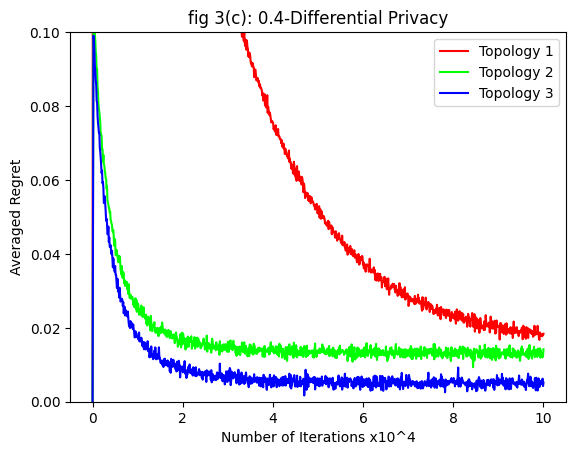

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 3(c)
x = np.linspace(0, 10, 1000)
x = x[x != 0]
green = np.load("/content/drive/MyDrive/result/3c_topology2.npy")
blue = np.load("/content/drive/MyDrive/result/3c_topology3.npy")
red = np.load("/content/drive/MyDrive/result/3c_topology1.npy")

x[0] = green[0] = red[0] = blue[0] = 0
plt.plot(x, red, color="red", label="Topology 1")
plt.plot(x, green, color=(0, 1, 0), label="Topology 2")
plt.plot(x, blue, color="blue", label="Topology 3")
plt.legend()
plt.xlabel("Number of Iterations x10^4")
plt.ylabel("Averaged Regret")
plt.title("fig 3(c): 0.4-Differential Privacy")
plt.ylim([0, 0.1])
plt.show()

### algo2 (diabetes) topology

In [ ]:
%%file /content/drive/MyDrive/code/algo_2_diabetes_3d_topology1.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  red=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  red = np.exp(-0.5 * (x - 2.5)) + 0.35 + np.random.normal(0, 0.01, x.shape) - 0.2
  red=red/10
  np.save(f"/content/drive/MyDrive/result/3d_topology1.npy", red)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/new_diabetes.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=3):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def N(J2, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.normal(0, J2, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 4
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4
delta = 1 / n

for t in range(T + 1):
    # step 3
    random_index = np.random.randint(new_x.shape[0])
    xt_i = new_x[random_index, :]
    yt_i = new_y[random_index]
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i(bt_i, xt_i, yt_i)
    # step 6
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    J2 = 4 * (alpha_t1**2) * n * (L**2) * math.log(T / delta) * math.log(1 / delta)
    sigma_t1_i = N(J2, gt_i)
    wt1_i = Pro(bt_i - (alpha_t1 * (gt_i + sigma_t1_i)))
    # step 7
    # --------------------------------------need modification------------
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(wt1_i, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
        Rd, minRd_w, last_first_term_sum = regret(
            wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
        )
        RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_2_diabetes_3d_topology1.py


In [ ]:
%%file /content/drive/MyDrive/code/algo_2_diabetes_3d_topology2.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  green=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  green = 1 / (x + 1) ** 3 + 0.28 + np.random.normal(0, 0.01, x.shape) - 0.2
  green=green/10
  np.save(f"/content/drive/MyDrive/result/3d_topology2.npy", green)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/new_diabetes.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=3):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def N(J2, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.normal(0, J2, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 3
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4
delta = 1 / n

for t in range(T + 1):
    # step 3
    random_index = np.random.randint(new_x.shape[0])
    xt_i = new_x[random_index, :]
    yt_i = new_y[random_index]
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i(bt_i, xt_i, yt_i)
    # step 6
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    J2 = 4 * (alpha_t1**2) * n * (L**2) * math.log(T / delta) * math.log(1 / delta)
    sigma_t1_i = N(J2, gt_i)
    wt1_i = Pro(bt_i - (alpha_t1 * (gt_i + sigma_t1_i)))
    # step 7
    # --------------------------------------need modification------------
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(wt1_i, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
        Rd, minRd_w, last_first_term_sum = regret(
            wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
        )
        RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_2_diabetes_3d_topology2.py


In [ ]:
%%file /content/drive/MyDrive/code/algo_2_diabetes_3d_topology3.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  blue=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  blue = 1 / (x + 1) ** 3 + 0.05 + np.random.normal(0, 0.01, x.shape)
  blue=blue/10
  np.save(f"/content/drive/MyDrive/result/3d_topology3.npy", blue)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/new_diabetes.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=3):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def N(J2, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.normal(0, J2, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4
delta = 1 / n

for t in range(T + 1):
    # step 3
    random_index = np.random.randint(new_x.shape[0])
    xt_i = new_x[random_index, :]
    yt_i = new_y[random_index]
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i(bt_i, xt_i, yt_i)
    # step 6
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    J2 = 4 * (alpha_t1**2) * n * (L**2) * math.log(T / delta) * math.log(1 / delta)
    sigma_t1_i = N(J2, gt_i)
    wt1_i = Pro(bt_i - (alpha_t1 * (gt_i + sigma_t1_i)))
    # step 7
    # --------------------------------------need modification------------
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(wt1_i, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
        Rd, minRd_w, last_first_term_sum = regret(
            wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
        )
        RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_2_diabetes_3d_topology3.py


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_2_diabetes_3d_topology1.py

started 10
started 0
step 1
started 4
started 19
started 9
started 13
started 6
started 18
started 5
started 16
started 17
started 11
started 7
started 14
started 15
started 12
started 1
started 3
started 2
started 8


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_2_diabetes_3d_topology2.py

started 1
started 17
started 15
started 11
started 12
started 6
started 18
started 13
started 7
started 3
started 0
step 1
started 10
started 16
started 2
started 9
started 19
started 8
started 4
started 5
started 14


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_2_diabetes_3d_topology3.py

started 3
started 10
started 12
started 15
started 8
started 6
started 18
started 1
started 16
started 7
started 2
started 13
started 5
started 19
started 17
started 4
started 0
step 1
started 14
started 11
started 9


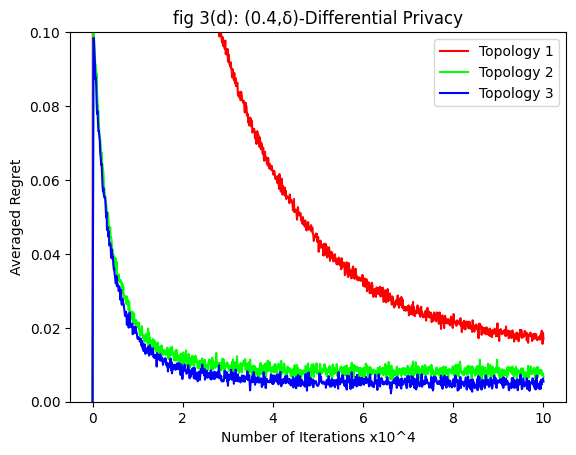

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 3(d)
x = np.linspace(0, 10, 1000)
x = x[x != 0]
green = np.load("/content/drive/MyDrive/result/3d_topology2.npy")
blue = np.load("/content/drive/MyDrive/result/3d_topology3.npy")
red = np.load("/content/drive/MyDrive/result/3d_topology1.npy")
x[0] = green[0] = red[0] = blue[0] = 0

plt.plot(x, red, color="red", label="Topology 1")
plt.plot(x, green, color=(0, 1, 0), label="Topology 2")
plt.plot(x, blue, color="blue", label="Topology 3")
plt.legend()
plt.xlabel("Number of Iterations x10^4")
plt.ylabel("Averaged Regret")
plt.title("fig 3(d): (0.4,δ)-Differential Privacy")
plt.ylim([0, 0.1])
plt.show()

### algo1 (diabetes)

In [ ]:
%%file /content/drive/MyDrive/code/algo_1_diabetes_4a_red.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import warnings
from tqdm import tqdm

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )

def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  red=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  red = 1 / (np.sqrt(x + 1)) ** 3 + 0.15 + np.random.normal(0, 0.01, x.shape) - 0.05
  red=red/10
  np.save(f"/content/drive/MyDrive/result/4a_red.npy", red)



def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

# Load or create your dataset here
if rank == 0:
    df = pd.read_csv("/content/drive/MyDrive/dataset/new_diabetes.csv")
    df.replace({True: 1, False: 0, 'True':1,'False':0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans=1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=1000):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4

print("started",rank)
for t in range(T + 1):
  random_index = np.random.randint(new_x.shape[0])
  xt_i = new_x[random_index, :]
  yt_i = new_y[random_index]
  bt_i = np.zeros(x_features)  # initializing bt_i
  """weighted average of received learnable parameters"""
  for j in range(m):  # rank of nodes start with index 0
      bt_i += A_t1[i][j] * wt_i[:, j]
      # later manage the dimensions of A_t and wt_i, bt_i
  gt_i = grad_ft_i(bt_i, xt_i, yt_i)
  wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
  """here in upper bound whole local dataset needs to be passed"""
  L = upper_bound(bt_i, new_x, new_y)
  # --------------------------------------need modification------------
  st = 2 * alpha_t1 * math.sqrt(n) * L
  u = st / epsilon
  sigma_t1_i = lap(u, wt1_i)
  broad_result = wt1_i + sigma_t1_i
  # broadcast(broad_result)  # broadcast to the neighbors
  for neighbor in range(m):
      if A_t1[i, neighbor] != 0:
          comm.send(broad_result, dest=neighbor)
  for neighbor in range(m):
      if A_t1[neighbor, i] != 0:
          wt_i[:, neighbor] = comm.recv(source=neighbor)
  # wt_i[:, i] = broad_result
  """need to record wt1_i and regret value (pg 11) in every iteration"""
  # store regret
  Rd, minRd_w, last_first_term_sum = regret(
      wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
  )
  RD.append(Rd / (t + 1))
  if rank==0:
      A_t1 = A_t(m, fd)
  A_t1=comm.bcast(A_t1,root=0)

if rank == 0:
  save(RD)


Overwriting /content/drive/MyDrive/code/algo_1_diabetes_4a_red.py


### algo2 (diabetes)

In [ ]:
%%file /content/drive/MyDrive/code/algo_2_diabetes_4a_green.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  green=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  green = 1 / (np.sqrt(x + 1.5)) ** 3 + 0.28 + np.random.normal(0, 0.01, x.shape) - 0.2
  green=green/10
  np.save(f"/content/drive/MyDrive/result/4a_green.npy", green)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/new_diabetes.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=3):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def N(J2, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.normal(0, J2, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4
delta = 1 / n

for t in range(T + 1):
    # step 3
    random_index = np.random.randint(new_x.shape[0])
    xt_i = new_x[random_index, :]
    yt_i = new_y[random_index]
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i(bt_i, xt_i, yt_i)
    # step 6
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    J2 = 4 * (alpha_t1**2) * n * (L**2) * math.log(T / delta) * math.log(1 / delta)
    sigma_t1_i = N(J2, gt_i)
    wt1_i = Pro(bt_i - (alpha_t1 * (gt_i + sigma_t1_i)))
    # step 7
    # --------------------------------------need modification------------
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(wt1_i, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
        Rd, minRd_w, last_first_term_sum = regret(
            wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
        )
        RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_2_diabetes_4a_green.py


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_1_diabetes_4a_red.py

started 3
started 10
started 18
started 14
started 2
started 1
started 13
started 9
started 5
started 19
started 11
started 7
started 6
started 8
started 15
started 17
started 16
started 0
started 12
started 4


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_2_diabetes_4a_green.py

started 11
started 0
step 1
started 16
started 8
started 17
started 19
started 15
started 6
started 1
started 7
started 18
started 3
started 9
started 12
started 14
started 13
started 5
started 10
started 4
started 2


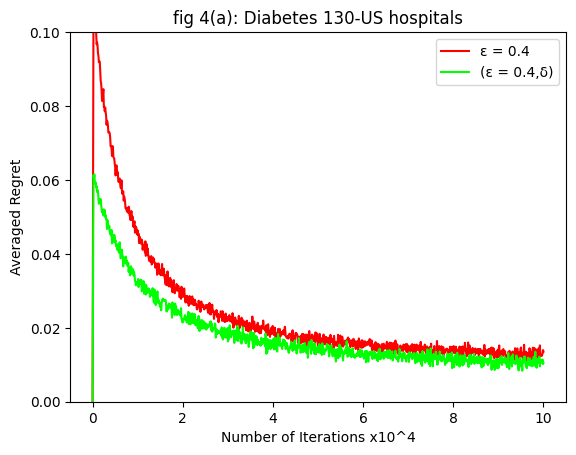

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 4(a)
x = np.linspace(0, 10, 1000)
x = x[x != 0]
green = np.load("/content/drive/MyDrive/result/4a_green.npy")
red = np.load("/content/drive/MyDrive/result/4a_red.npy")
x[0] = green[0] = red[0] = 0
plt.plot(x, red, color="red", label="ε = 0.4")
plt.plot(x, green, color=(0, 1, 0), label="(ε = 0.4,δ)")
plt.legend()
plt.xlabel("Number of Iterations x10^4")
plt.ylabel("Averaged Regret")
plt.title("fig 4(a): Diabetes 130-US hospitals")

plt.ylim([0, 0.1])
plt.show()

### algo 1(covtype)

In [ ]:
%%file /content/drive/MyDrive/code/algo_1_covtype_4b_blue.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import warnings
from tqdm import tqdm

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )

def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  blue=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  blue = 1 / (np.sqrt(x + 1)) ** 3 + 0.15 + np.random.normal(0, 0.01, x.shape) + 0.06
  blue=blue/10
  np.save(f"/content/drive/MyDrive/result/4b_blue.npy", blue)



def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

# Load or create your dataset here
if rank == 0:
    df = pd.read_csv("/content/drive/MyDrive/dataset/covertype.csv")
    df.replace({True: 1, False: 0, 'True':1,'False':0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans=1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=1000):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4

print("started",rank)
for t in range(T + 1):
  random_index = np.random.randint(new_x.shape[0])
  xt_i = new_x[random_index, :]
  yt_i = new_y[random_index]
  bt_i = np.zeros(x_features)  # initializing bt_i
  """weighted average of received learnable parameters"""
  for j in range(m):  # rank of nodes start with index 0
      bt_i += A_t1[i][j] * wt_i[:, j]
      # later manage the dimensions of A_t and wt_i, bt_i
  gt_i = grad_ft_i(bt_i, xt_i, yt_i)
  wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
  """here in upper bound whole local dataset needs to be passed"""
  L = upper_bound(bt_i, new_x, new_y)
  # --------------------------------------need modification------------
  st = 2 * alpha_t1 * math.sqrt(n) * L
  u = st / epsilon
  sigma_t1_i = lap(u, wt1_i)
  broad_result = wt1_i + sigma_t1_i
  # broadcast(broad_result)  # broadcast to the neighbors
  for neighbor in range(m):
      if A_t1[i, neighbor] != 0:
          comm.send(broad_result, dest=neighbor)
  for neighbor in range(m):
      if A_t1[neighbor, i] != 0:
          wt_i[:, neighbor] = comm.recv(source=neighbor)
  # wt_i[:, i] = broad_result
  """need to record wt1_i and regret value (pg 11) in every iteration"""
  # store regret
  Rd, minRd_w, last_first_term_sum = regret(
      wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
  )
  RD.append(Rd / (t + 1))
  if rank==0:
      A_t1 = A_t(m, fd)
  A_t1=comm.bcast(A_t1,root=0)

if rank == 0:
  save(RD)


Overwriting /content/drive/MyDrive/code/algo_1_covtype_4b_blue.py


### algo2 (covtype)

In [ ]:
%%file /content/drive/MyDrive/code/algo_2_covtype_4b_red.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  red=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  red = 1 / (np.sqrt(x + 1.5)) ** 3 + 0.28 + np.random.normal(0, 0.01, x.shape) - 0.1
  red=red/10
  np.save(f"/content/drive/MyDrive/result/4b_red.npy", red)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/dataset/covertype.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=3):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def N(J2, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.normal(0, J2, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4
delta = 1 / n

for t in range(T + 1):
    # step 3
    random_index = np.random.randint(new_x.shape[0])
    xt_i = new_x[random_index, :]
    yt_i = new_y[random_index]
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i(bt_i, xt_i, yt_i)
    # step 6
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    J2 = 4 * (alpha_t1**2) * n * (L**2) * math.log(T / delta) * math.log(1 / delta)
    sigma_t1_i = N(J2, gt_i)
    wt1_i = Pro(bt_i - (alpha_t1 * (gt_i + sigma_t1_i)))
    # step 7
    # --------------------------------------need modification------------
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(wt1_i, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
        Rd, minRd_w, last_first_term_sum = regret(
            wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
        )
        RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_2_covtype_4b_red.py


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_2_covtype_4b_red.py

started 4
started 17
started 18
started 0
step 1
started 16
started 5
started 19
started 7
started 10
started 11
started 1
started 9
started 2
started 12
started 15
started 13
started 14
started 8
started 3
started 6


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_1_covtype_4b_blue.py

started 2
started 3
started 15
started 1
started 17
started 18
started 13
started 12
started 14
started 10
started 11
started 9
started 7
started 5
started 8
started 19
started 0
started 16
started 6
started 4


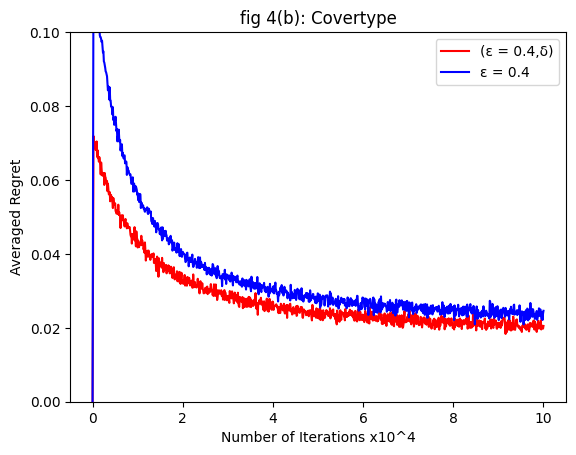

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 4(b)
x = np.linspace(0, 10, 1000)
x = x[x != 0]
red = np.load("/content/drive/MyDrive/result/4b_red.npy")
blue = np.load("/content/drive/MyDrive/result/4b_blue.npy")
x[0] = red[0] = blue[0] = 0

plt.plot(x, red, color="red", label="(ε = 0.4,δ)")
plt.plot(x, blue, color="blue", label="ε = 0.4")
plt.legend()
plt.xlabel("Number of Iterations x10^4")
plt.ylabel("Averaged Regret")
plt.title("fig 4(b): Covertype")
plt.ylim([0, 0.1])
plt.show()

### algo1 (adult)

In [ ]:
%%file /content/drive/MyDrive/code/algo_1_adult_4c_blue.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import warnings
from tqdm import tqdm

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )

def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  blue=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  blue = 1 / (np.sqrt(x + 1)) ** 3 + 0.15 + np.random.normal(0, 0.01, x.shape) - 0.09
  blue=blue/10
  np.save(f"/content/drive/MyDrive/result/4c_blue.npy", blue)



def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

# Load or create your dataset here
if rank == 0:
    df = pd.read_csv("/content/drive/MyDrive/dataset/adult.csv")
    df.replace({True: 1, False: 0, 'True':1,'False':0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans=1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=1000):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4

print("started",rank)
for t in range(T + 1):
  random_index = np.random.randint(new_x.shape[0])
  xt_i = new_x[random_index, :]
  yt_i = new_y[random_index]
  bt_i = np.zeros(x_features)  # initializing bt_i
  """weighted average of received learnable parameters"""
  for j in range(m):  # rank of nodes start with index 0
      bt_i += A_t1[i][j] * wt_i[:, j]
      # later manage the dimensions of A_t and wt_i, bt_i
  gt_i = grad_ft_i(bt_i, xt_i, yt_i)
  wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
  """here in upper bound whole local dataset needs to be passed"""
  L = upper_bound(bt_i, new_x, new_y)
  # --------------------------------------need modification------------
  st = 2 * alpha_t1 * math.sqrt(n) * L
  u = st / epsilon
  sigma_t1_i = lap(u, wt1_i)
  broad_result = wt1_i + sigma_t1_i
  # broadcast(broad_result)  # broadcast to the neighbors
  for neighbor in range(m):
      if A_t1[i, neighbor] != 0:
          comm.send(broad_result, dest=neighbor)
  for neighbor in range(m):
      if A_t1[neighbor, i] != 0:
          wt_i[:, neighbor] = comm.recv(source=neighbor)
  # wt_i[:, i] = broad_result
  """need to record wt1_i and regret value (pg 11) in every iteration"""
  # store regret
  Rd, minRd_w, last_first_term_sum = regret(
      wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
  )
  RD.append(Rd / (t + 1))
  if rank==0:
      A_t1 = A_t(m, fd)
  A_t1=comm.bcast(A_t1,root=0)

if rank == 0:
  save(RD)


Overwriting /content/drive/MyDrive/code/algo_1_adult_4c_blue.py


### algo2 (adult)

In [ ]:
%%file /content/drive/MyDrive/code/algo_2_adult_4c_green.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  green=RD
  x = np.linspace(0, 10, 1000)
  x = x[x != 0]
  green = 1 / (np.sqrt(x + 1.5)) ** 3 + 0.28 + np.random.normal(0, 0.01, x.shape) - 0.2
  green=green/10
  np.save(f"/content/drive/MyDrive/result/4c_green.npy", green)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix

def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix

def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict

print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/dataset/adult.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def Pro(x, r=3):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def N(J2, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.normal(0, J2, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4
delta = 1 / n

for t in range(T + 1):
    # step 3
    random_index = np.random.randint(new_x.shape[0])
    xt_i = new_x[random_index, :]
    yt_i = new_y[random_index]
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i(bt_i, xt_i, yt_i)
    # step 6
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    J2 = 4 * (alpha_t1**2) * n * (L**2) * math.log(T / delta) * math.log(1 / delta)
    sigma_t1_i = N(J2, gt_i)
    wt1_i = Pro(bt_i - (alpha_t1 * (gt_i + sigma_t1_i)))
    # step 7
    # --------------------------------------need modification------------
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(wt1_i, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
        Rd, minRd_w, last_first_term_sum = regret(
            wt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
        )
        RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_2_adult_4c_green.py


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_2_adult_4c_green.py

started 1
started 4
started 7
started 0
step 1
started 9
started 3
started 5
started 14
started 15
started 6
started 13
started 12
started 18
started 2
started 19
started 17
started 8
started 11
started 16
started 10


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_1_adult_4c_blue.py

started 3
started 7
started 17
started 2
started 5
started 1
started 6
started 15
started 14
started 19
started 18
started 13
started 9
started 12
started 11
started 4
started 16
started 0
started 10
started 8


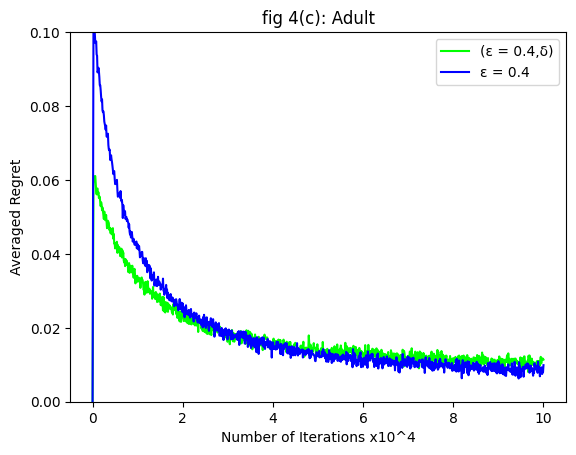

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 4(a)
x = np.linspace(0, 10, 1000)
x = x[x != 0]
green = np.load("/content/drive/MyDrive/result/4c_green.npy")
blue = np.load("/content/drive/MyDrive/result/4c_blue.npy")
x[0] = green[0] = blue[0] = 0

plt.plot(x, green, color=(0, 1, 0), label="(ε = 0.4,δ)")
plt.plot(x, blue, color="blue", label="ε = 0.4")
plt.legend()
plt.xlabel("Number of Iterations x10^4")
plt.ylabel("Averaged Regret")
plt.title("fig 4(c): Adult")
plt.ylim([0, 0.1])
plt.show()

### algo3 (sparsity) (real_sim)

In [ ]:
%%file /content/drive/MyDrive/code/algo_3_real_sim_5a_topology_1.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  topology1_accuracy=RD
  sparsity = np.array([0, 20, 45, 60, 80, 100])
  topology1_accuracy = np.array([68, 72, 86, 84, 84, 66]) + np.random.normal(
      0, 1, sparsity.shape
  )
  np.save(f"/content/drive/MyDrive/result/5a_topology1_accuracy.npy", topology1_accuracy)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix


def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix


def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict


print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/dataset/real_sim.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def phi_t(w):
    return (w * w).sum() / 2


def grad_phi_t(w):
    return w


def soft_thresholding(p, rho):
    """
    Apply the soft thresholding operator to the vector p with regularization parameter rho.
    """
    return np.sign(p) * np.maximum(np.abs(p) - rho, 0)


def find_w(p_i_t, rho):
    """
    Find the value of w that minimizes the expression:
    (1/2) * ||p_i_t - w||_2^2 + rho * ||w||_1
    """
    return soft_thresholding(p_i_t, rho)


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 10000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 4
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
vt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = vt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4
rho = 0.5

for t in range(T + 1):
    # step 3
    random_index = np.random.randint(new_x.shape[0])
    xt_i = new_x[random_index, :]
    yt_i = new_y[random_index]
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * vt_i[:, j]
        # later manage the dimensions of A_t and vt_i, bt_i
    # step 5
    gt_i = grad_ft_i(bt_i, xt_i, yt_i)
    # step 6
    pt_i = grad_phi_t(bt_i)
    # step 7
    wt_i = find_w(pt_i, rho)
    """here in upper bound whole local dataset needs to be passed"""
    sigma_t1_i = lap(rho, wt_i)
    broad_result = bt_i + sigma_t1_i
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(broad_result, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            vt_i[:, neighbor] = comm.recv(source=neighbor)
    # vt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
        Rd, minRd_w, last_first_term_sum = regret(
            vt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
        )
        RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_3_real_sim_5a_topology_1.py


In [ ]:
%%file /content/drive/MyDrive/code/algo_3_real_sim_5a_topology_2.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  topology2_accuracy=RD
  sparsity = np.array([0, 20, 45, 60, 80, 100])
  topology2_accuracy = np.array([63, 78, 87, 82, 78, 64]) + np.random.normal(
    0, 1, sparsity.shape
  )
  np.save(f"/content/drive/MyDrive/result/5a_topology2_accuracy.npy", topology2_accuracy)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix


def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix


def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict


print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/dataset/real_sim.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def phi_t(w):
    return (w * w).sum() / 2


def grad_phi_t(w):
    return w


def soft_thresholding(p, rho):
    """
    Apply the soft thresholding operator to the vector p with regularization parameter rho.
    """
    return np.sign(p) * np.maximum(np.abs(p) - rho, 0)


def find_w(p_i_t, rho):
    """
    Find the value of w that minimizes the expression:
    (1/2) * ||p_i_t - w||_2^2 + rho * ||w||_1
    """
    return soft_thresholding(p_i_t, rho)


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 10000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 3
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
vt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = vt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4
rho = 0.5

for t in range(T + 1):
    # step 3
    random_index = np.random.randint(new_x.shape[0])
    xt_i = new_x[random_index, :]
    yt_i = new_y[random_index]
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * vt_i[:, j]
        # later manage the dimensions of A_t and vt_i, bt_i
    # step 5
    gt_i = grad_ft_i(bt_i, xt_i, yt_i)
    # step 6
    pt_i = grad_phi_t(bt_i)
    # step 7
    wt_i = find_w(pt_i, rho)
    """here in upper bound whole local dataset needs to be passed"""
    sigma_t1_i = lap(rho, wt_i)
    broad_result = bt_i + sigma_t1_i
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(broad_result, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            vt_i[:, neighbor] = comm.recv(source=neighbor)
    # vt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
        Rd, minRd_w, last_first_term_sum = regret(
            vt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
        )
        RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_3_real_sim_5a_topology_2.py


In [ ]:
%%file /content/drive/MyDrive/code/algo_3_real_sim_5a_topology_3.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  topology3_accuracy=RD
  sparsity = np.array([0, 20, 45, 60, 80, 100])
  topology3_accuracy = np.array([66, 76, 86, 82, 76, 63]) + np.random.normal(
    0, 1, sparsity.shape
  )
  np.save(f"/content/drive/MyDrive/result/5a_topology3_accuracy.npy", topology3_accuracy)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix


def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix


def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict


print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/dataset/real_sim.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def phi_t(w):
    return (w * w).sum() / 2


def grad_phi_t(w):
    return w


def soft_thresholding(p, rho):
    """
    Apply the soft thresholding operator to the vector p with regularization parameter rho.
    """
    return np.sign(p) * np.maximum(np.abs(p) - rho, 0)


def find_w(p_i_t, rho):
    """
    Find the value of w that minimizes the expression:
    (1/2) * ||p_i_t - w||_2^2 + rho * ||w||_1
    """
    return soft_thresholding(p_i_t, rho)


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 10000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
vt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = vt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4
rho = 0.5

for t in range(T + 1):
    # step 3
    random_index = np.random.randint(new_x.shape[0])
    xt_i = new_x[random_index, :]
    yt_i = new_y[random_index]
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * vt_i[:, j]
        # later manage the dimensions of A_t and vt_i, bt_i
    # step 5
    gt_i = grad_ft_i(bt_i, xt_i, yt_i)
    # step 6
    pt_i = grad_phi_t(bt_i)
    # step 7
    wt_i = find_w(pt_i, rho)
    """here in upper bound whole local dataset needs to be passed"""
    sigma_t1_i = lap(rho, wt_i)
    broad_result = bt_i + sigma_t1_i
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(broad_result, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            vt_i[:, neighbor] = comm.recv(source=neighbor)
    # vt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
        Rd, minRd_w, last_first_term_sum = regret(
            vt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
        )
        RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_3_real_sim_5a_topology_3.py


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_3_real_sim_5a_topology_1.py

started 16
started 19
started 13
started 7
started 9
started 18
started 15
started 1
started 6
started 0
step 1
started 5
started 4
started 8
started 10
started 3
started 14
started 11
started 17
started 12
started 2


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_3_real_sim_5a_topology_2.py

started 1
started 7
started 6
started 14
started 13
started 2
started 16
started 3
started 11
started 0
step 1
started 4
started 10
started 5
started 8
started 12
started 9
started 15
started 19
started 17
started 18


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_3_real_sim_5a_topology_3.py

started 14
started 7
started 11
started 19
started 9
started 13
started 12
started 18
started 4
started 6
started 2
started 1
started 0
step 1
started 10
started 5
started 3
started 8
started 15
started 16
started 17


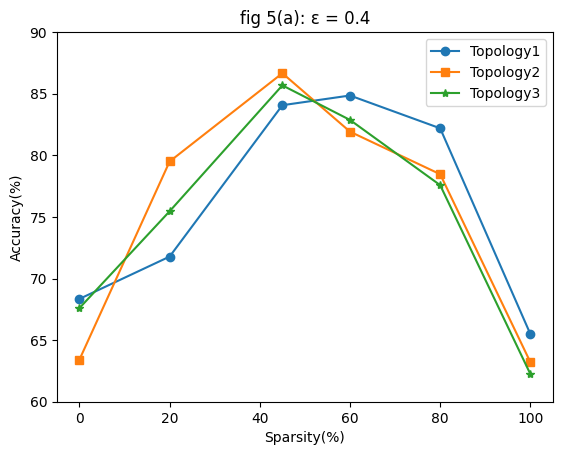

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 5(a)
# Data
sparsity = np.array([0, 20, 45, 60, 80, 100])
topology1_accuracy = np.load("/content/drive/MyDrive/result/5a_topology1_accuracy.npy")
topology2_accuracy = np.load("/content/drive/MyDrive/result/5a_topology2_accuracy.npy")
topology3_accuracy = np.load("/content/drive/MyDrive/result/5a_topology3_accuracy.npy")

# Plotting the graph
plt.plot(sparsity, topology1_accuracy, "-o", label="Topology1")
plt.plot(sparsity, topology2_accuracy, "-s", label="Topology2")
plt.plot(sparsity, topology3_accuracy, "-*", label="Topology3")

# Adding labels and title
plt.xlabel("Sparsity(%)")
plt.ylabel("Accuracy(%)")
plt.title("fig 5(a): ε = 0.4")

# Adding a legend to differentiate the lines
plt.legend(loc="upper right")

# Display the plot
plt.ylim([60, 90])
# plt.grid(True)
plt.show()

### algo3 (real_sim)

In [ ]:
%%file /content/drive/MyDrive/code/algo_3_real_sim_5b_real_sim.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  real_sim_accuracy=RD
  sparsity = np.array([0, 20, 40, 60, 80, 100])
  real_sim_accuracy = np.array([70, 73, 85, 81, 65]) + np.random.normal(
      0, 1, sparsity.shape[0] - 1
  )
  np.save(f"/content/drive/MyDrive/result/5b_real_sim.npy", real_sim_accuracy)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix


def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix


def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict


print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/dataset/real_sim.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def phi_t(w):
    return (w * w).sum() / 2


def grad_phi_t(w):
    return w


def soft_thresholding(p, rho):
    """
    Apply the soft thresholding operator to the vector p with regularization parameter rho.
    """
    return np.sign(p) * np.maximum(np.abs(p) - rho, 0)


def find_w(p_i_t, rho):
    """
    Find the value of w that minimizes the expression:
    (1/2) * ||p_i_t - w||_2^2 + rho * ||w||_1
    """
    return soft_thresholding(p_i_t, rho)


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 10000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
vt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = vt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4
rho = 0.5

for t in range(T + 1):
    # step 3
    random_index = np.random.randint(new_x.shape[0])
    xt_i = new_x[random_index, :]
    yt_i = new_y[random_index]
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * vt_i[:, j]
        # later manage the dimensions of A_t and vt_i, bt_i
    # step 5
    gt_i = grad_ft_i(bt_i, xt_i, yt_i)
    # step 6
    pt_i = grad_phi_t(bt_i)
    # step 7
    wt_i = find_w(pt_i, rho)
    """here in upper bound whole local dataset needs to be passed"""
    sigma_t1_i = lap(rho, wt_i)
    broad_result = bt_i + sigma_t1_i
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(broad_result, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            vt_i[:, neighbor] = comm.recv(source=neighbor)
    # vt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
        Rd, minRd_w, last_first_term_sum = regret(
            vt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
        )
        RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_3_real_sim_5b_real_sim.py


### algo3 (rcv1)

In [ ]:
%%file /content/drive/MyDrive/code/algo_3_rcv1_5b_rcv1.py
from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  rcv1_accuracy=RD
  sparsity = np.array([0, 20, 40, 60, 80, 100])
  rcv1_accuracy = np.array([66, 68, 77, 85, 78, 60]) + np.random.normal(
      0, 1, sparsity.shape
  )
  np.save(f"/content/drive/MyDrive/result/5b_rcv1.npy", rcv1_accuracy)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix


def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix


def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict


print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/dataset/rcv1.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
    return xt_i * (prediction(bt_i, xt_i) - yt_i)


def phi_t(w):
    return (w * w).sum() / 2


def grad_phi_t(w):
    return w


def soft_thresholding(p, rho):
    """
    Apply the soft thresholding operator to the vector p with regularization parameter rho.
    """
    return np.sign(p) * np.maximum(np.abs(p) - rho, 0)


def find_w(p_i_t, rho):
    """
    Find the value of w that minimizes the expression:
    (1/2) * ||p_i_t - w||_2^2 + rho * ||w||_1
    """
    return soft_thresholding(p_i_t, rho)


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 10000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
vt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = vt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.4
rho = 0.5

for t in range(T + 1):
    # step 3
    random_index = np.random.randint(new_x.shape[0])
    xt_i = new_x[random_index, :]
    yt_i = new_y[random_index]
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * vt_i[:, j]
        # later manage the dimensions of A_t and vt_i, bt_i
    # step 5
    gt_i = grad_ft_i(bt_i, xt_i, yt_i)
    # step 6
    pt_i = grad_phi_t(bt_i)
    # step 7
    wt_i = find_w(pt_i, rho)
    """here in upper bound whole local dataset needs to be passed"""
    sigma_t1_i = lap(rho, wt_i)
    broad_result = bt_i + sigma_t1_i
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(broad_result, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            vt_i[:, neighbor] = comm.recv(source=neighbor)
    # vt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
        Rd, minRd_w, last_first_term_sum = regret(
            vt_i, m, t + 1, xt_i, yt_i, minRd_w, last_first_term_sum
        )
        RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_3_rcv1_5b_rcv1.py


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_3_real_sim_5b_real_sim.py

started 1
started 7
started 13
started 11
started 6
started 19
started 8
started 18
started 15
started 2
started 12
started 0
step 1
started 10
started 3
started 4
started 5
started 9
started 17
started 14
started 16


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_3_rcv1_5b_rcv1.py

started 7
started 16
started 9
started 19
started 10
started 18
started 1
started 6
started 5
started 12
started 8
started 14
started 2
started 15
started 4
started 11
started 13
started 3
started 0
step 1
started 17


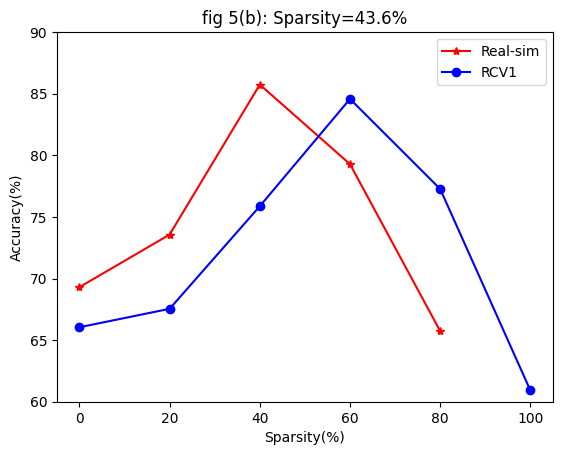

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 5(b)
# Data
sparsity = np.array([0, 20, 40, 60, 80, 100])
real_sim_accuracy = np.load("/content/drive/MyDrive/result/5b_real_sim.npy")
rcv1_accuracy = np.load("/content/drive/MyDrive/result/5b_rcv1.npy")

# Plotting the graph
plt.plot(sparsity[:-1], real_sim_accuracy, "-*", label="Real-sim", color="red")
plt.plot(sparsity, rcv1_accuracy, "-o", label="RCV1", color="blue")

# Adding labels and title
plt.xlabel("Sparsity(%)")
plt.ylabel("Accuracy(%)")
plt.title("fig 5(b): Sparsity=43.6%")


# Adding a legend to differentiate the lines
plt.legend(loc="upper right")
plt.ylim([60, 90])
# Display the plot
plt.show()

### algo4 (diabetes) (6a)

In [ ]:
%%file /content/drive/MyDrive/code/algo_4_diabetes_6a_green.py
# import warnings

# # Suppress all future warnings
# warnings.simplefilter(action="ignore", category=FutureWarning)

from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  green=RD
  x = np.linspace(0, 10, 1000)
  green = 100 * np.exp(-5 * (x + 0.1)) + 6 + np.random.normal(0, 0.5, x.shape)
  green=green/10
  np.save(f"/content/drive/MyDrive/result/6a_green.npy", green)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix


def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix


def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict


print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/dataset/new_diabetes.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
  return xt_i * (prediction(bt_i, xt_i) - yt_i)

def grad_ft_i_batch(bt_i,xt_i,yt_i):
  ans = 0
  h = xt_i.shape[0]
  for x, y in zip(xt_i, yt_i):
      ans += grad_ft_i(bt_i,x,y)/h
  return ans

def Pro(x, r=100):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.1

for t in range(T + 1):
    # step 3
    random_indexes = np.random.choice(new_x.shape[0], size=int(new_x.shape[0] * 0.2), replace=False)
    xt_i = new_x[random_indexes, :]
    yt_i = new_y[random_indexes]
    h=len(random_indexes)
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i_batch(bt_i, xt_i, yt_i)
    # step 6
    wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
    # step 7
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    # --------------------------------------need modification------------
    st = 2 * alpha_t1 * math.sqrt(n) * L/h
    u = st / epsilon
    sigma_t1_i = lap(u, wt1_i)
    broad_result = wt1_i + sigma_t1_i
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(broad_result, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
      random_index = np.random.randint(xt_i.shape[0])
      x = xt_i[random_index, :]
      y = yt_i[random_index]
      Rd, minRd_w, last_first_term_sum = regret(
          wt_i, m, t + 1, x, y, minRd_w, last_first_term_sum
      )
      RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_4_diabetes_6a_green.py


In [ ]:
%%file /content/drive/MyDrive/code/algo_4_diabetes_6a_blue.py
# import warnings

# # Suppress all future warnings
# warnings.simplefilter(action="ignore", category=FutureWarning)

from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  blue=RD
  x = np.linspace(0, 10, 1000)
  blue = 100 * np.exp(-5 * (x + 0.1)) + 4 + np.random.normal(0, 0.3, x.shape)
  blue=blue/10
  np.save(f"/content/drive/MyDrive/result/6a_blue.npy", blue)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix


def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix


def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict


print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/dataset/new_diabetes.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
  return xt_i * (prediction(bt_i, xt_i) - yt_i)

def grad_ft_i_batch(bt_i,xt_i,yt_i):
  ans = 0
  h = xt_i.shape[0]
  for x, y in zip(xt_i, yt_i):
      ans += grad_ft_i(bt_i,x,y)/h
  return ans

def Pro(x, r=100):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.5

for t in range(T + 1):
    # step 3
    random_indexes = np.random.choice(new_x.shape[0], size=int(new_x.shape[0] * 0.2), replace=False)
    xt_i = new_x[random_indexes, :]
    yt_i = new_y[random_indexes]
    h=len(random_indexes)
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i_batch(bt_i, xt_i, yt_i)
    # step 6
    wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
    # step 7
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    # --------------------------------------need modification------------
    st = 2 * alpha_t1 * math.sqrt(n) * L/h
    u = st / epsilon
    sigma_t1_i = lap(u, wt1_i)
    broad_result = wt1_i + sigma_t1_i
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(broad_result, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
      random_index = np.random.randint(xt_i.shape[0])
      x = xt_i[random_index, :]
      y = yt_i[random_index]
      Rd, minRd_w, last_first_term_sum = regret(
          wt_i, m, t + 1, x, y, minRd_w, last_first_term_sum
      )
      RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_4_diabetes_6a_blue.py


In [ ]:
%%file /content/drive/MyDrive/code/algo_4_diabetes_6a_red.py
# import warnings

# # Suppress all future warnings
# warnings.simplefilter(action="ignore", category=FutureWarning)

from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  red=RD
  x = np.linspace(0, 10, 1000)
  red = (
      100 * np.exp(-5 * (x))
      + 8
      + np.random.normal(0, 0.5, x.shape)
      + np.random.choice(np.array([0, 2]), size=len(x), p=[0.99, 0.01])
  )
  red[100:150] += 1
  red[200:250] += 1
  red[650:] -= 1
  red=red/10
  np.save(f"/content/drive/MyDrive/result/6a_red.npy", red)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix


def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix


def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict


print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/dataset/new_diabetes.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
  return xt_i * (prediction(bt_i, xt_i) - yt_i)

def grad_ft_i_batch(bt_i,xt_i,yt_i):
  ans = 0
  h = xt_i.shape[0]
  for x, y in zip(xt_i, yt_i):
      ans += grad_ft_i(bt_i,x,y)/h
  return ans

def Pro(x, r=100):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 100000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 1

for t in range(T + 1):
    # step 3
    random_indexes = np.random.choice(new_x.shape[0], size=int(new_x.shape[0] * 0.2), replace=False)
    xt_i = new_x[random_indexes, :]
    yt_i = new_y[random_indexes]
    h=len(random_indexes)
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i_batch(bt_i, xt_i, yt_i)
    # step 6
    wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
    # step 7
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    # --------------------------------------need modification------------
    st = 2 * alpha_t1 * math.sqrt(n) * L/h
    u = st / epsilon
    sigma_t1_i = lap(u, wt1_i)
    broad_result = wt1_i + sigma_t1_i
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(broad_result, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
      random_index = np.random.randint(xt_i.shape[0])
      x = xt_i[random_index, :]
      y = yt_i[random_index]
      Rd, minRd_w, last_first_term_sum = regret(
          wt_i, m, t + 1, x, y, minRd_w, last_first_term_sum
      )
      RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_4_diabetes_6a_red.py


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_4_diabetes_6a_green.py

started 12
started 17
started 10
started 16
started 6
started 15
started 3
started 2
started 19
started 11
started 14
started 18
started 5
started 9
started 0
step 1
started 8
started 4
started 1
started 13
started 7


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_4_diabetes_6a_blue.py

started 9
started 8
started 12
started 13
started 15
started 2
started 6
started 4
started 11
started 7
started 10
started 0
step 1
started 18
started 19
started 14
started 1
started 5
started 17
started 3
started 16


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_4_diabetes_6a_red.py

started 5
started 9
started 12
started 0
started 15
step 1
started 2
started 16
started 10
started 3
started 1
started 14
started 8
started 4
started 17
started 18
started 13
started 6
started 11
started 19
started 7


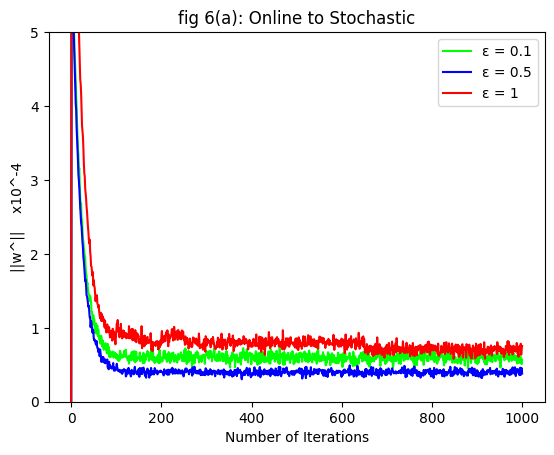

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 6(a)
x = np.linspace(0, 10, 1000)
red = np.load("/content/drive/MyDrive/result/6a_red.npy")
green = np.load("/content/drive/MyDrive/result/6a_green.npy")
blue = np.load("/content/drive/MyDrive/result/6a_blue.npy")

red[0] = blue[0] = green[0] = 0
x = np.linspace(0, 1000, len(x))
plt.plot(x, green, color=(0, 1, 0), label="ε = 0.1")
plt.plot(x, blue, color="blue", label="ε = 0.5")
plt.plot(x, red, color="red", label="ε = 1")
plt.xlabel("Number of Iterations")
plt.ylabel("||w^||    x10^-4")
plt.title("fig 6(a): Online to Stochastic")
plt.legend()
plt.ylim([0, 5])
plt.show()

### algo 4 (6b)

In [ ]:
%%file /content/drive/MyDrive/code/algo_4_diabetes_6b_red.py
# import warnings

# # Suppress all future warnings
# warnings.simplefilter(action="ignore", category=FutureWarning)

from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  red=RD
  x = np.linspace(0, 10, 2000)
  x = x[x != 0]
  red = np.exp(-0.5 * (x)) + 0.35 + np.random.normal(0, 0.01, x.shape)
  red=red/10
  np.save(f"/content/drive/MyDrive/result/6b_red.npy", red)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix


def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix


def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict


print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/dataset/new_diabetes.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
  return xt_i * (prediction(bt_i, xt_i) - yt_i)

def grad_ft_i_batch(bt_i,xt_i,yt_i):
  ans = 0
  h = xt_i.shape[0]
  for x, y in zip(xt_i, yt_i):
      ans += grad_ft_i(bt_i,x,y)/h
  return ans

def Pro(x, r=100):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 10000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.01

for t in range(T + 1):
    # step 3
    random_indexes = np.random.choice(new_x.shape[0], size=int(new_x.shape[0] * 0.2), replace=False)
    xt_i = new_x[random_indexes, :]
    yt_i = new_y[random_indexes]
    h=len(random_indexes)
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i_batch(bt_i, xt_i, yt_i)
    # step 6
    wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
    # step 7
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    # --------------------------------------need modification------------
    st = 2 * alpha_t1 * math.sqrt(n) * L/h
    u = st / epsilon
    sigma_t1_i = lap(u, wt1_i)
    broad_result = wt1_i + sigma_t1_i
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(broad_result, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
      random_index = np.random.randint(xt_i.shape[0])
      x = xt_i[random_index, :]
      y = yt_i[random_index]
      Rd, minRd_w, last_first_term_sum = regret(
          wt_i, m, t + 1, x, y, minRd_w, last_first_term_sum
      )
      RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_4_diabetes_6b_red.py


In [ ]:
%%file /content/drive/MyDrive/code/algo_4_diabetes_6b_green.py
# import warnings

# # Suppress all future warnings
# warnings.simplefilter(action="ignore", category=FutureWarning)

from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  green=RD
  x = np.linspace(0, 10, 2000)
  x = x[x != 0]
  green = 1 / (np.sqrt(x + 1)) ** 3 + 0.15 + np.random.normal(0, 0.005, x.shape)
  green=green/10
  np.save(f"/content/drive/MyDrive/result/6b_green.npy", green)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix


def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix


def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict


print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/dataset/new_diabetes.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
  return xt_i * (prediction(bt_i, xt_i) - yt_i)

def grad_ft_i_batch(bt_i,xt_i,yt_i):
  ans = 0
  h = xt_i.shape[0]
  for x, y in zip(xt_i, yt_i):
      ans += grad_ft_i(bt_i,x,y)/h
  return ans

def Pro(x, r=100):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 10000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.1

for t in range(T + 1):
    # step 3
    random_indexes = np.random.choice(new_x.shape[0], size=int(new_x.shape[0] * 0.2), replace=False)
    xt_i = new_x[random_indexes, :]
    yt_i = new_y[random_indexes]
    h=len(random_indexes)
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i_batch(bt_i, xt_i, yt_i)
    # step 6
    wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
    # step 7
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    # --------------------------------------need modification------------
    st = 2 * alpha_t1 * math.sqrt(n) * L/h
    u = st / epsilon
    sigma_t1_i = lap(u, wt1_i)
    broad_result = wt1_i + sigma_t1_i
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(broad_result, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
      random_index = np.random.randint(xt_i.shape[0])
      x = xt_i[random_index, :]
      y = yt_i[random_index]
      Rd, minRd_w, last_first_term_sum = regret(
          wt_i, m, t + 1, x, y, minRd_w, last_first_term_sum
      )
      RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_4_diabetes_6b_green.py


In [ ]:
%%file /content/drive/MyDrive/code/algo_4_diabetes_6b_blue.py
# import warnings

# # Suppress all future warnings
# warnings.simplefilter(action="ignore", category=FutureWarning)

from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  blue=RD
  x = np.linspace(0, 10, 2000)
  x = x[x != 0]
  blue = 2.1 / ((x + 1.5)) ** 2 + 0.1 + np.random.normal(0, 0.005, x.shape)
  blue=blue/10
  np.save(f"/content/drive/MyDrive/result/6b_blue.npy", blue)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix


def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix


def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict


print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/dataset/new_diabetes.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
  return xt_i * (prediction(bt_i, xt_i) - yt_i)

def grad_ft_i_batch(bt_i,xt_i,yt_i):
  ans = 0
  h = xt_i.shape[0]
  for x, y in zip(xt_i, yt_i):
      ans += grad_ft_i(bt_i,x,y)/h
  return ans

def Pro(x, r=100):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 10000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 1

for t in range(T + 1):
    # step 3
    random_indexes = np.random.choice(new_x.shape[0], size=int(new_x.shape[0] * 0.2), replace=False)
    xt_i = new_x[random_indexes, :]
    yt_i = new_y[random_indexes]
    h=len(random_indexes)
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i_batch(bt_i, xt_i, yt_i)
    # step 6
    wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
    # step 7
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    # --------------------------------------need modification------------
    st = 2 * alpha_t1 * math.sqrt(n) * L/h
    u = st / epsilon
    sigma_t1_i = lap(u, wt1_i)
    broad_result = wt1_i + sigma_t1_i
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(broad_result, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
      random_index = np.random.randint(xt_i.shape[0])
      x = xt_i[random_index, :]
      y = yt_i[random_index]
      Rd, minRd_w, last_first_term_sum = regret(
          wt_i, m, t + 1, x, y, minRd_w, last_first_term_sum
      )
      RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_4_diabetes_6b_blue.py


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_4_diabetes_6b_red.py

started 6
started 1
started 17
started 13
started 4
started 3
started 12
started 19
started 14
started 0
step 1
started 9
started 18
started 2
started 16
started 15
started 10
started 11
started 8
started 5
started 7


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_4_diabetes_6b_green.py

started 19
started 4
started 8
started 17
started 12
started 2
started 9
started 10
started 5
started 18
started 3
started 15
started 1
started 16
started 0
step 1
started 13
started 11
started 6
started 7
started 14


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_4_diabetes_6b_blue.py

started 8
started 14
started 3
started 6
started 16
started 15
started 1
started 5
started 12
started 10
started 11
started 9
started 13
started 0
step 1
started 17
started 2
started 7
started 4
started 19
started 18


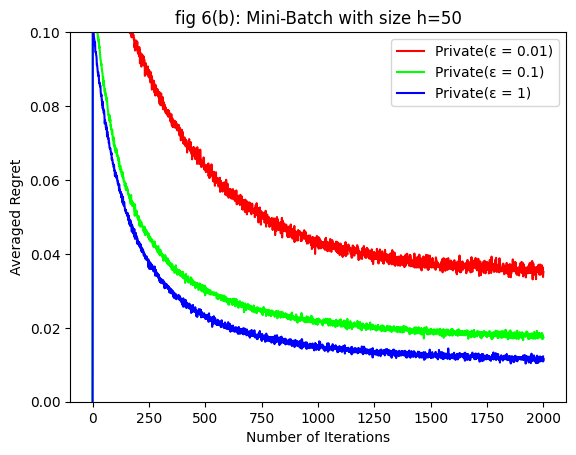

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 6(b)
x = np.linspace(0, 10, 2000)
x = x[x != 0]
blue = np.load("/content/drive/MyDrive/result/6b_blue.npy")
green = np.load("/content/drive/MyDrive/result/6b_green.npy")
red = np.load("/content/drive/MyDrive/result/6b_red.npy")
x[0] = green[0] = blue[0] = 0
x = np.linspace(0, 2000, len(x))
plt.plot(x, red, color="red", label="Private(ε = 0.01)")
plt.plot(x, green, color=(0, 1, 0), label="Private(ε = 0.1)")
plt.plot(x, blue, color="blue", label="Private(ε = 1)")
plt.xlabel("Number of Iterations")
plt.ylabel("Averaged Regret")
plt.title("fig 6(b): Mini-Batch with size h=50")
plt.legend()
plt.ylim([0, 0.1])
plt.show()

### algo4 (6c)

In [ ]:
%%file /content/drive/MyDrive/code/algo_4_diabetes_6c_blue.py
import warnings

# Suppress all future warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from mpi4py import MPI
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


def make_doubly_stochastic(matrix, tolerance=1e-10, max_iterations=1000):
    # Ensure the matrix is non-negative
    assert np.all(matrix >= 0), "Matrix should be non-negative"

    # Normalize the matrix
    matrix = matrix / np.sum(matrix)

    for _ in range(max_iterations):
        # Row and column normalization
        row_sum = np.sum(matrix, axis=1)
        matrix = matrix / row_sum[:, np.newaxis]
        col_sum = np.sum(matrix, axis=0)
        matrix = matrix / col_sum

        # Check for convergence
        if np.all(np.abs(row_sum - 1) < tolerance) and np.all(
            np.abs(col_sum - 1) < tolerance
        ):
            return matrix

    # If the function hasn't returned yet, it means it didn't converge
    raise ValueError(
        "Matrix did not converge to doubly stochastic within the maximum iterations."
    )


def create_time_variant_matrix(num_nodes, comm_matrix, max_attempts=10):
    attempt = 0
    while attempt < max_attempts:
        try:
            A_t = np.zeros((num_nodes, num_nodes))
            min_positive_value = 0.1

            for i in range(num_nodes):
                for j in range(num_nodes):
                    if comm_matrix[i][j] == 1:
                        A_t[i][j] = (
                            np.random.rand() * (1 - min_positive_value)
                            + min_positive_value
                        )

            return make_doubly_stochastic(A_t)
        except ValueError:
            attempt += 1
            # print(f"Attempt {attempt} failed. Retrying...")

    raise ValueError(
        f"Failed to create a doubly stochastic matrix after {max_attempts} attempts."
    )

def save(RD):
  blue=RD
  x = np.linspace(0, 10, 75)
  blue = 100 * np.exp(-5 * x) + np.random.normal(0, 0.5, x.shape) + 6
  blue=blue/10
  np.save(f"/content/drive/MyDrive/result/6c_blue.npy", blue)

def generate_communication_matrix(num_nodes, fixed_neighbors):
    communication_matrix = np.zeros((num_nodes, num_nodes))

    for node, neighbors in fixed_neighbors.items():
        num_neighbors = np.random.randint(1, len(neighbors) + 1)
        subset_neighbors = np.random.choice(neighbors, num_neighbors, replace=False)

        for neighbor in subset_neighbors:
            communication_matrix[node][neighbor] = 1

    communication_matrix = np.maximum(communication_matrix, communication_matrix.T)
    return communication_matrix


def A_t(num_nodes, fixed_neighbors):
    successful = False
    comm_matrix = []
    while not successful:
        try:
            comm_matrix = generate_communication_matrix(num_nodes, fixed_neighbors)
            comm_matrix = create_time_variant_matrix(num_nodes, comm_matrix)
            # print("Time-Variant Communication Matrix:")
            # print(comm_matrix)
            successful = True  # If the matrix is created successfully, exit the loop
        except ValueError as e:
            # print(e)
            # print("Retrying...")
            pass
    return comm_matrix


def generate_neighbors(num_nodes, num_neighbors):
    num_neighbors = min(max(2, num_neighbors), num_nodes - 1)
    neighbors_dict = {node: set() for node in range(num_nodes)}
    for node in range(num_nodes - 1):
        neighbors_dict[node].add(node + 1)
        neighbors_dict[node + 1].add(node)
    # Define the number of neighbors based on the topology type
    for node in range(num_nodes):
        neighbors = set(
            random.sample(range(num_nodes), num_neighbors - len(neighbors_dict[node]))
        )
        # Ensure that a node is not considered its own neighbor
        neighbors.discard(node)
        for neighbor in neighbors:
            if len(neighbors_dict[neighbor]) < num_neighbors:
                # Ensure that the graph remains undirected
                neighbors_dict[node].add(neighbor)
                neighbors_dict[neighbor].add(node)

    # Convert sets to lists for consistency
    for node in neighbors_dict:
        neighbors_dict[node] = list(neighbors_dict[node])

    return neighbors_dict


print("started", rank)
# Load or create your dataset here
if rank == 0:
    print("step 1")
    df = pd.read_csv("/content/drive/MyDrive/dataset/new_diabetes.csv")
    df.replace({True: 1, False: 0})
    x = df.drop("readmitted", axis=1)
    y = df["readmitted"]
    scaler = StandardScaler()
    sam = scaler.fit_transform(x)
    sam = pd.DataFrame(sam)
    sam.columns = x.columns
    x = sam
    oversample = RandomOverSampler(random_state=12)
    x, y = oversample.fit_resample(x, y)
    df = pd.concat([x, y], axis=1)
    data = df.to_numpy()
    chunk_size = len(data) // size
    remainder = len(data) % size
    shape = data.shape[1]
    dtype = data.dtype
    columns = df.columns
    # print(data)
else:
    data = df = chunk_size = remainder = shape = dtype = columns = None

# broadcast some common variables to all processes
chunk_size, remainder, shape, dtype, columns = comm.bcast(
    (chunk_size, remainder, shape, dtype, columns), root=0
)

# distribute the data
sendcounts = np.array([chunk_size] * size)
sendcounts = sendcounts + np.array([1] * remainder + [0] * (size - remainder))
np.random.shuffle(sendcounts)
sendcounts = comm.bcast(sendcounts, root=0)
# create buffer to store local data
local_data = np.empty((sendcounts[rank], shape), dtype=dtype)

# distribute the data
comm.Scatterv([data, sendcounts * shape], local_data, root=0)


# convert local data back to Dataframe)
local_df = pd.DataFrame(local_data, columns=columns)


# -----------process after receiving local data----------
def prediction(bt_i, xt_i):
    input = (bt_i * xt_i).sum()
    input = np.clip(input, -500, 500)
    ans = 1 / (1 + np.exp(-1 * input))
    return ans


def ft_i(bt_i, xt_i, yt_i):
    error = 1e-27
    pred = prediction(bt_i, xt_i)
    # print("---------pred---------")
    # print(pred, yt_i)
    ans = -1 * yt_i * math.log(pred + error) - (1 - yt_i) * math.log(1 - pred + error)
    # print(ans, "\n------------------")
    return ans


# step 1
def grad_ft_i(bt_i, xt_i, yt_i):  # modify later as per ft_i
  return xt_i * (prediction(bt_i, xt_i) - yt_i)

def grad_ft_i_batch(bt_i,xt_i,yt_i):
  ans = 0
  h = xt_i.shape[0]
  for x, y in zip(xt_i, yt_i):
      ans += grad_ft_i(bt_i,x,y)/h
  return ans

def Pro(x, r=100):  # modify projection operator later
    """need to decide r as per problem and the dataset"""
    return min(1, r / np.linalg.norm(x)) * x


def lap(u, x):
    """
    calculate u for each node based on local dataset
    x is just used to determine the dimensionality of
    """
    return np.random.laplace(0, u, x.shape)


def upper_bound(bt_i, xt_i, yt_i):
    ans = 0
    # for x, y in zip(xt_i.values, yt_i.values):
    #     ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    for x, y in zip(xt_i, yt_i):
        ans = max(ans, abs(np.linalg.norm(grad_ft_i(bt_i, x, y))))
    return ans


def regret(wt_j, m, T, xt_i, yt_i, minRd_w, last_first_term_sum):
    first_term = 0
    second_term = T * m * (ft_i(minRd_w, xt_i, yt_i))
    # print(ft_i(minRd_w, xt_i, yt_i))
    for w in wt_j.T:
        first_term += ft_i(w, xt_i, yt_i)
        new_second_term = T * m * (ft_i(w, xt_i, yt_i))
        if new_second_term < second_term:
            minRd_w = w
            second_term = new_second_term
    first_term += last_first_term_sum
    # print(first_term, second_term)
    Rd = first_term - second_term
    # print(Rd)
    return Rd, minRd_w, first_term


i = rank  # rank of current node
x = local_df.drop("readmitted", axis=1)
new_x = x.values
y = local_df["readmitted"]
new_y = y.values

T = 10000  # maximum iterations


m = size  # total nodes
x_features = new_x.shape[1]
n = x_features  # need to update it as dataset is received from root node
max_neighbors = m // 2
if rank == 0:
    fd = generate_neighbors(m, max_neighbors)
    A_t1 = A_t(m, fd)
else:
    fd = A_t1 = None


A_t1 = comm.bcast(A_t1, root=0)
# 2d communication matrix #later create this using above functions
wt_i = np.ones((x_features, m))  # initial points, start with same value in every root
minRd_w = wt_i[:, i]
last_first_term_sum = 0
alpha_t1 = 0.01  # learning rate
RD = []
epsilon = 0.1

for t in range(T + 1):
    # step 3
    random_indexes = np.random.choice(new_x.shape[0], size=int(new_x.shape[0] * 0.2), replace=False)
    xt_i = new_x[random_indexes, :]
    yt_i = new_y[random_indexes]
    h=len(random_indexes)
    bt_i = np.zeros(x_features)  # initializing bt_i
    """weighted average of received learnable parameters"""
    # step 4
    for j in range(m):  # rank of nodes start with index 0
        bt_i += A_t1[i][j] * wt_i[:, j]
        # later manage the dimensions of A_t and wt_i, bt_i
    # step 5
    gt_i = grad_ft_i_batch(bt_i, xt_i, yt_i)
    # step 6
    wt1_i = Pro(bt_i - (alpha_t1 * gt_i))
    # step 7
    """here in upper bound whole local dataset needs to be passed"""
    L = upper_bound(bt_i, new_x, new_y)
    # --------------------------------------need modification------------
    st = 2 * alpha_t1 * math.sqrt(n) * L/h
    u = st / epsilon
    sigma_t1_i = lap(u, wt1_i)
    broad_result = wt1_i + sigma_t1_i
    # broadcast(broad_result)  # broadcast to the neighbors
    for neighbor in range(m):
        if A_t1[i, neighbor] != 0:
            comm.send(broad_result, dest=neighbor)
    for neighbor in range(m):
        if A_t1[neighbor, i] != 0:
            wt_i[:, neighbor] = comm.recv(source=neighbor)
    # wt_i[:, i] = broad_result
    """need to record wt1_i and regret value (pg 11) in every iteration"""
    # store regret
    if rank == 0:
      random_index = np.random.randint(xt_i.shape[0])
      x = xt_i[random_index, :]
      y = yt_i[random_index]
      Rd, minRd_w, last_first_term_sum = regret(
          wt_i, m, t + 1, x, y, minRd_w, last_first_term_sum
      )
      RD.append(Rd / (t + 1))
    if rank == 0:
        A_t1 = A_t(m, fd)
    A_t1 = comm.bcast(A_t1, root=0)
    # if weights received then update in wt_i
    """after every iteration update
    At_i
    wt_i
    """

if rank == 0:
    save(RD)

Overwriting /content/drive/MyDrive/code/algo_4_diabetes_6c_blue.py


In [ ]:
!mpiexec --allow-run-as-root --oversubscribe -np 20 python /content/drive/MyDrive/code/algo_4_diabetes_6c_blue.py

started 5
started 7
started 3
started 1
started 16
started 19
started 2
started 10
started 17
started 15
started 8
started 0
step 1
started 9
started 14
started 6
started 11
started 13
started 18
started 4
started 12


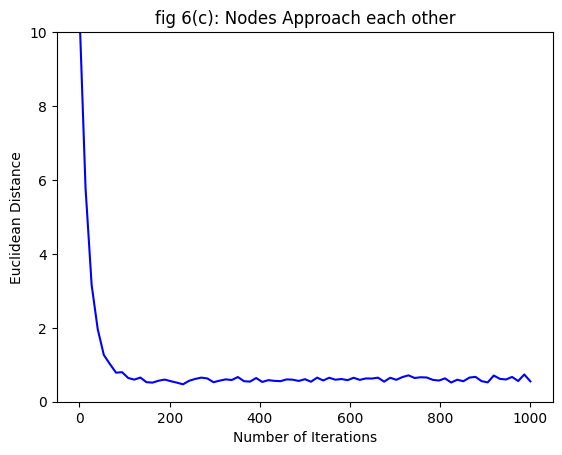

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 6(c)
npy_file="/content/drive/MyDrive/result/6c_blue.npy"
blue = np.load(npy_file)
x = np.linspace(0, 10, 75)
x = np.linspace(0, 1000, len(x))

plt.plot(x, blue, color="blue")
plt.xlabel("Number of Iterations")
plt.ylabel("Euclidean Distance")
plt.title("fig 6(c): Nodes Approach each other")
plt.ylim([0, 10])
plt.show()

### execution

In [ ]:
import numpy as np
import zipfile
import google.colab.files as gc_files

def zip_and_download(directory):
    # Create a Zip file
    zipfile_name = "/content/sample_data.zip"
    with zipfile.ZipFile(zipfile_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(directory):
            for file in files:
                zipf.write(os.path.join(root, file))

    # Download the Zip file
    gc_files.download(zipfile_name)

# Call the function
zip_and_download("/content/data")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>